In [2]:
import torch
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree, RegionGraph
from cirkit.symbolic.layers import GaussianLayer
from cirkit.symbolic.parameters import mixing_weight_factory
from cirkit.templates.utils import Parameterization, parameterization_to_factory

In [3]:
from cirkit.pipeline import compile as cirkit_compile
from torch.cuda.amp import autocast, GradScaler        # mixed precision (optional)
from cirkit.pipeline import compile
from cirkit.pipeline import PipelineContext
import functools
from cirkit.symbolic.layers import HadamardLayer,SumLayer
from cirkit.templates.utils import InputLayerFactory,SumLayerFactory,ProductLayerFactory
from cirkit.symbolic.parameters import ParameterFactory
from typing import Sequence

In [5]:
def build_circuit2(
        self,
        *,
        input_factory: InputLayerFactory,
        sum_product: str | None = None,
        sum_weight_factory: ParameterFactory | None = None,
        nary_sum_weight_factory: ParameterFactory | None = None,
        sum_factory: SumLayerFactory | None = None,
        prod_factory: ProductLayerFactory | None = None,
        num_input_units: int = 1,
        num_sum_units: int = 1,
        num_classes: int = 1,
        factorize_multivariate: bool = True,
    ) -> Circuit:
        """Construct a symbolic circuit from a region graph.
            There are two ways to use this method. The first one is to specify a sum-product layer
            abstraction, which can be either 'cp' (the CP layer), 'cp-t' (the CP-transposed layer),
            or 'tucker' (the Tucker layer). The second one is to manually specify the factories to
            build distinct um and product layers. If the first way is chosen, then one can possibly
            use a factory that builds the symbolic parameters of the sum-product layer abstractions.
            The factory that constructs the input factory must always be specified.

        Args:
            input_factory: A factory that builds an input layer.
            sum_product: The sum-product layer to use. It can be None, 'cp', 'cp-t', or 'tucker'.
            sum_weight_factory: The factory to construct the weights of the sum layers.
                It can be None, or a parameter factory, i.e., a map
                from a shape to a symbolic parameter. If it is None, then the default
                weight factory of the sum layer is used instead.
            nary_sum_weight_factory: The factory to construct the weight of sum layers havity arity
                greater than one. If it is None, then it will have the same value and semantics of
                the given sum_weight_factory.
            sum_factory: A factory that builds a sum layer. It can be None.
            prod_factory: A factory that builds a product layer. It can be None.
            num_input_units: The number of input units.
            num_sum_units: The number of sum units per sum layer.
            num_classes: The number of output classes.
            factorize_multivariate: Whether to fully factorize input layers, when they depend on
                more than one variable.

        Returns:
            Circuit: A symbolic circuit.

        Raises:
            NotImplementedError: If an unknown 'sum_product' is given.
            ValueError: If both 'sum_product' and layer factories are specified, or none of them.
            ValueError: If 'sum_product' is specified, but 'weight_factory' is not.
            ValueError: The given region graph is malformed.
        """
        if (sum_factory is None and prod_factory is not None) or (
            sum_factory is not None and prod_factory is None
        ):
            raise ValueError(
                "Both 'sum_factory' and 'prod_factory' must be specified or none of them"
            )
        if sum_product is None and (sum_factory is None or prod_factory is None):
            raise ValueError(
                "If 'sum_product' is not given, then both 'sum_factory' and 'prod_factory'"
                " must be specified"
            )
        if sum_product is not None and (sum_factory is not None or prod_factory is not None):
            raise ValueError(
                "At most one between 'sum_product' and the pair 'sum_factory' and 'prod_factory'"
                " must be specified"
            )
        if nary_sum_weight_factory is None:
            nary_sum_weight_factory = sum_weight_factory

        layers: list[Layer] = []
        in_layers: dict[Layer, list[Layer]] = {}
        node_to_layer: dict[RegionGraphNode, Layer] = {}

        def build_cp_(
            rgn: RegionNode, rgn_partitioning: Sequence[RegionNode]
        ) -> HadamardLayer | SumLayer:
            layer_ins = [node_to_layer[rgn_in] for rgn_in in rgn_partitioning]
            # fetch the already‐built layers for each child
        
            # sanity check: make sure all child outputs have the same dimensionality
            dims = [l.num_output_units for l in layer_ins]
            assert len(set(dims)) == 1, "Can't element-wise sum different dims"
        
            # build one SumLayer that takes BOTH inputs at once
            sum_layer = SumLayer(
                num_input_units = dims[0],       # input vector size
                num_output_units = num_sum_units,# your chosen output size
                arity = len(layer_ins),          # here, 2
                weight_factory = sum_weight_factory
            )
        
            # record it in your bookkeeping
            layers.append(sum_layer)
            in_layers[sum_layer] = layer_ins
            node_to_layer[rgn] = sum_layer
        
            return sum_layer

        def build_cp_transposed_(
            rgn: RegionNode, rgn_partitioning: Sequence[RegionNode]
        ) -> SumLayer:
            layer_ins = [node_to_layer[rgn_in] for rgn_in in rgn_partitioning]
            num_in_units = list({li.num_output_units for li in layer_ins})
            if len(num_in_units) > 1:
                raise ValueError(
                    "Cannot build a CP transposed layer, as the inputs would have different units"
                )
            num_units = num_sum_units if self.region_outputs(rgn) else num_classes
            hadamard = HadamardLayer(num_in_units[0], arity=len(rgn_partitioning))
            dense = SumLayer(num_in_units[0], num_units, weight_factory=sum_weight_factory)
            layers.append(hadamard)
            layers.append(dense)
            in_layers[hadamard] = layer_ins
            in_layers[dense] = [hadamard]
            node_to_layer[rgn] = dense
            return dense

        def build_tucker_(rgn: RegionNode, rgn_partitioning: Sequence[RegionNode]) -> SumLayer:
            layer_ins = [node_to_layer[rgn_in] for rgn_in in rgn_partitioning]
            num_in_units = list({li.num_output_units for li in layer_ins})
            if len(num_in_units) > 1:
                raise ValueError(
                    "Cannot build a Tucker layer, as the inputs would have different units"
                )
            num_units = num_sum_units if self.region_outputs(rgn) else num_classes
            kronecker = KroneckerLayer(num_in_units[0], arity=len(rgn_partitioning))
            dense = SumLayer(
                kronecker.num_output_units,
                num_units,
                weight_factory=sum_weight_factory,
            )
            layers.append(kronecker)
            layers.append(dense)
            in_layers[kronecker] = layer_ins
            in_layers[dense] = [kronecker]
            node_to_layer[rgn] = dense
            return dense

        # Set the sum-product layer builder, if necessary
        sum_prod_builder_: Callable[[RegionNode, Sequence[RegionNode]], Layer] | None
        if sum_product is None:
            sum_prod_builder_ = None
        elif sum_product == "cp":
            sum_prod_builder_ = build_cp_
        elif sum_product == "cp-t":
            sum_prod_builder_ = build_cp_transposed_
        elif sum_product == "tucker":
            sum_prod_builder_ = build_tucker_
        else:
            raise NotImplementedError(f"Unknown sum-product layer abstraction called {sum_product}")

        # Loop through the region graph nodes, which are already sorted in a topological ordering
        for node in self.topological_ordering():
            if isinstance(node, PartitionNode):  # Partition node
                # If a sum-product layer abstraction has been specified,
                # then just skip partition nodes
                if sum_prod_builder_ is not None:
                    continue
                assert prod_factory is not None
                partition_inputs = self.partition_inputs(node)
                prod_inputs = [node_to_layer[rgn] for rgn in partition_inputs]
                prod_sl = prod_factory(num_sum_units, len(prod_inputs))
                layers.append(prod_sl)
                in_layers[prod_sl] = prod_inputs
                node_to_layer[node] = prod_sl
            assert isinstance(
                node, RegionNode
            ), "Region graph nodes must be either region or partition nodes"
            region_inputs = self.region_inputs(node)
            region_outputs = self.region_outputs(node)
            if not region_inputs:
                # Input region node
                if factorize_multivariate and len(node.scope) > 1:
                    factorized_input_sls = [
                        input_factory(Scope([sc]), num_input_units) for sc in node.scope
                    ]
                    input_sl = HadamardLayer(num_input_units, arity=len(factorized_input_sls))
                    layers.extend(factorized_input_sls)
                    in_layers[input_sl] = factorized_input_sls
                else:
                    input_sl = input_factory(node.scope, num_input_units)
                num_units = num_sum_units if self.region_outputs(node) else num_classes
                if sum_factory is None:
                    layers.append(input_sl)
                    node_to_layer[node] = input_sl
                    continue
                sum_sl = sum_factory(num_input_units, num_units)
                layers.append(input_sl)
                layers.append(sum_sl)
                in_layers[sum_sl] = [input_sl]
                node_to_layer[node] = sum_sl
            elif len(region_inputs) == 1:
                # Region node that is partitioned into one and only one way
                (ptn,) = region_inputs
                if sum_prod_builder_ is not None:
                    sum_prod_builder_(node, self.partition_inputs(ptn))
                    continue
                num_units = num_sum_units if region_outputs else num_classes
                sum_input = node_to_layer[ptn]
                sum_sl = sum_factory(sum_input.num_output_units, num_units)
                layers.append(sum_sl)
                in_layers[sum_sl] = [sum_input]
                node_to_layer[node] = sum_sl
            else:  # len(node_inputs) > 1:
                # Region node with multiple partitionings
                num_units = num_sum_units if region_outputs else num_classes
                if sum_prod_builder_ is None:
                    sum_ins = [node_to_layer[ptn] for ptn in region_inputs]
                    mix_ins = [sum_factory(sli.num_output_units, num_units) for sli in sum_ins]
                    layers.extend(mix_ins)
                    for mix_sl, sli in zip(mix_ins, sum_ins):
                        in_layers[mix_sl] = [sli]
                else:
                    mix_ins = [
                        sum_prod_builder_(node, self.partition_inputs(cast(PartitionNode, ptn)))
                        for ptn in region_inputs
                    ]
                mix_sl = SumLayer(
                    num_units,
                    num_units,
                    arity=len(mix_ins),
                    weight_factory=nary_sum_weight_factory,
                )
                layers.append(mix_sl)
                in_layers[mix_sl] = mix_ins
                node_to_layer[node] = mix_sl

        outputs = [node_to_layer[rgn] for rgn in self.outputs]
        print(layers,"---------------\n\n\n",in_layers,"---------------\n\n\n",outputs)
        return Circuit(layers, in_layers, outputs)

In [6]:
def define_circuit(rg: RegionGraph,
                   num_input_units: int,
                   num_sum_units: int,
                   sum_prod_layer: str = "cp") -> Circuit:
    """Return an over-parameterized Circuit given a region-graph."""
    # Input layer (Gaussian) is over-parameterized by num_input_units →
    input_factory = lambda scope, _: GaussianLayer(scope=scope,
                                                   num_output_units=num_input_units)

    # Sum-layer parameterization (softmax-normal initialisation)
    sum_param   = Parameterization(activation="softmax", initialization="normal")
    sum_factory = parameterization_to_factory(sum_param)

    # Special case: mixing (n-ary sum) layers
    nary_factory = functools.partial(mixing_weight_factory,
                                     param_factory=sum_factory)
    rg.build_circuit = MethodType(build_circuit2, rg)   # <─ bound to rg only
    circuit = rg.build_circuit(
        input_factory        = input_factory,
        sum_weight_factory   = sum_factory,
        nary_sum_weight_factory = nary_factory,
        num_input_units      = num_input_units,
        num_sum_units        = num_sum_units,
        sum_product          = sum_prod_layer,
    )
    return circuit


[GaussianLayer(scope=Scope({1}), num_output_units=1, config=(scope=Scope({1}), num_output_units=1)params=(mean=Parameter(shape=(1,)), stddev=Parameter(shape=(1,)))), GaussianLayer(scope=Scope({0}), num_output_units=1, config=(scope=Scope({0}), num_output_units=1)params=(mean=Parameter(shape=(1,)), stddev=Parameter(shape=(1,)))), SumLayer(num_input_units=1, num_output_units=1, arity=2, config=(num_input_units=1, num_output_units=1, arity=2), params=(weight=Parameter(shape=(1, 2)))] ---------------


 {SumLayer(num_input_units=1, num_output_units=1, arity=2, config=(num_input_units=1, num_output_units=1, arity=2), params=(weight=Parameter(shape=(1, 2))): [GaussianLayer(scope=Scope({1}), num_output_units=1, config=(scope=Scope({1}), num_output_units=1)params=(mean=Parameter(shape=(1,)), stddev=Parameter(shape=(1,)))), GaussianLayer(scope=Scope({0}), num_output_units=1, config=(scope=Scope({0}), num_output_units=1)params=(mean=Parameter(shape=(1,)), stddev=Parameter(shape=(1,))))]} -------

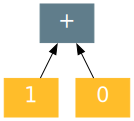

In [12]:
from types import MethodType
from cirkit.symbolic.io import plot_circuit
from cirkit.templates.region_graph.graph import PartitionNode,RegionNode
rg = RandomBinaryTree(2, depth=None, num_repetitions=1,seed=42)
net = define_circuit(rg,
                     num_input_units = 1,
                     num_sum_units   = 1,
                     sum_prod_layer  = "cp")
print(net)
from cirkit.symbolic.io import plot_circuit
if plot_circuit is not None:
    dot = plot_circuit(net, orientation="vertical")
    display(dot)

In [8]:
from cirkit.backend.torch.semiring import SemiringImpl,SumProductSemiring
[print(x) for x in SemiringImpl.list()]

sum-product
lse-sum
complex-lse-sum


[None, None, None]

In [9]:
probs = torch.tensor([0.2, 0.3, 0.5,7.0])
result = SumProductSemiring.sum(probs)  # result = 1.0
print(result)
x = torch.tensor([[[1.0, 2.0]]])           # shape (1, 1, 2) = (F, B, I)
weight = torch.tensor([[[4, 1.0]]])

# Apply semiring einsum
result = SumProductSemiring.einsum(
    "fbi,foi->fbo", inputs=(x,), operands=(weight,), dim=-1, keepdim=True
)
print(result)

tensor(8.)
tensor([[[6.]]])


In [21]:
torch.manual_seed(42)
ctx = PipelineContext(
    backend='torch',      # Use the PyTorch backend
    # Specify the backend compilation flags next
    #semiring='lse-sum',   # Use the 'lse-sum' semiring
    semiring='sum-product', 
    fold=False,            # Enable circuit folding
    # -------- Enable layer optimizations -------- #
    optimize=False, # NOTE: THIS IS AN IMPORTANT FLAG (false for kronecker true for einsum)
    # -------------------------------------------- #
)
cc = ctx.compile(net).to(torch.device("cpu"))
print(cc)
# 'net' is your TorchCircuit instance
print("-------")
for name, param in cc.named_parameters():
    print(f"{name:30s} shape={tuple(param.shape)}")
    print(param.data)   # the raw tensor
    print()




TorchCircuit(
  (0): TorchGaussianLayer(
    folds: 1  variables: 1  output-units: 1
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 1)
    (mean): TorchParameter(
      shape: (1, 1)
      (0): TorchTensorParameter(output-shape: (1, 1))
    )
    (stddev): TorchParameter(
      shape: (1, 1)
      (0): TorchTensorParameter(output-shape: (1, 1))
      (1): TorchScaledSigmoidParameter(
        input-shapes: [(1, 1)]
        output-shape: (1, 1)
      )
    )
  )
  (1): TorchGaussianLayer(
    folds: 1  variables: 1  output-units: 1
    input-shape: (1, 1, -1, 1)
    output-shape: (1, -1, 1)
    (mean): TorchParameter(
      shape: (1, 1)
      (0): TorchTensorParameter(output-shape: (1, 1))
    )
    (stddev): TorchParameter(
      shape: (1, 1)
      (0): TorchTensorParameter(output-shape: (1, 1))
      (1): TorchScaledSigmoidParameter(
        input-shapes: [(1, 1)]
        output-shape: (1, 1)
      )
    )
  )
  (2): TorchSumLayer(
    folds: 1  arity: 2  input-units: 1  ou

In [22]:
cc.eval()
test = torch.tensor([[0.5,1],[0,0]])
print(test.shape)
cc(test)

torch.Size([2, 2])


tensor([[[0.5561]],

        [[0.6435]]], grad_fn=<TransposeBackward0>)

In [23]:
from cirkit.backend.torch.layers.input import TorchGaussianLayer
from cirkit.backend.torch.layers.inner import TorchSumLayer
# 1) Grab *all* sub-modules…
all_submodules = list(cc.modules())

# 2) Filter out just the Gaussians and the Sum layer
layers = [
    m for m in all_submodules
    if isinstance(m, (TorchGaussianLayer, TorchSumLayer))
]

# 3) Check you got three
#print(layers)   # ->
g0, g1, sum_layer = layers
# Just call the parameter object directly:
print(g0.mean())  # Or: your_layer.mean[0].forward()
print(g0.stddev()[0])
print("----")


x0 = torch.reshape(torch.tensor([0.5]),[1,1,-1,1])
x1 = torch.reshape(torch.tensor([1.0]),[1,1,-1,1])
x1, x0 = x0, x1
l0 = g0(x0)     # same as g0.forward(x0)
l1 = g1(x1)
print(l0,l1)

input_shape = torch.reshape(torch.tensor([[[[l0,l1]]]]),[1,2,-1,1])
print("input-shape",input_shape)
out = sum_layer(input_shape)
print(out)      

tensor([[0.3367]], grad_fn=<IndexBackward0>)
tensor([0.5322], grad_fn=<SelectBackward0>)
----
tensor([[[[0.3447]]]], grad_fn=<ExpBackward0>) tensor([[[[0.6390]]]], grad_fn=<ExpBackward0>)
input-shape tensor([[[[0.3447]],

         [[0.6390]]]])
tensor([[[0.5561]]], grad_fn=<ViewBackward0>)


In [24]:
import torch
from torch.distributions import Normal

# 1) Extract the transformed parameters:
mu0    = g0.mean._nodes[0]._ptensor          # e.g. tensor([[0.3367]])
raw_s0 = g0.stddev._nodes[0]._ptensor        # raw
s0     = g0.stddev._nodes[1].forward(raw_s0) # after sigmoid


mu1    = g1.mean._nodes[0]._ptensor          # e.g. tensor([[0.1288]])
raw_s1 = g1.stddev._nodes[0]._ptensor
s1     = g1.stddev._nodes[1].forward(raw_s1)


# 2) Compute the PDFs
x0 = torch.tensor([0.5])
x1 = torch.tensor([1.0])

pdf0 = Normal(mu0, s0).log_prob(x0).exp()
pdf1 = Normal(mu1, s1).log_prob(x1).exp()
print(mu0,raw_s0,s0)
print("----")
print(mu1,raw_s1,s1)
print("----")
print(pdf0)  # ≃ tensor([[[[0.7152]]]])
print(pdf1)  # ≃ tensor([[[[0.2787]]]])


Parameter containing:
tensor([[0.3367]], requires_grad=True) Parameter containing:
tensor([[0.1288]], requires_grad=True) tensor([[0.5322]], grad_fn=<AddBackward0>)
----
Parameter containing:
tensor([[0.2345]], requires_grad=True) Parameter containing:
tensor([[0.2303]], requires_grad=True) tensor([[0.5573]], grad_fn=<AddBackward0>)
----
tensor([[0.7152]], grad_fn=<ExpBackward0>)
tensor([[0.2787]], grad_fn=<ExpBackward0>)


In [25]:
import math
p11=0.7152
p22=0.2787
p1=1.3866
p2=0.0069
w1=-1.1229
w2=-0.1863
#softmax
a1 = math.exp(w1)/(math.exp(w1)+math.exp(w2))
a2= math.exp(w2)/(math.exp(w1)+math.exp(w2))
print(a1,a2)
print(a1*l0+a2*l1)

0.28158763807102954 0.7184123619289705
tensor([[[[0.5561]]]], grad_fn=<AddBackward0>)


In [26]:
print(sum_layer(torch.tensor([[[[1.0,0.0]]]])))
print(sum_layer(torch.tensor([[[[0.0,1.0]]]])))
print(sum_layer(torch.tensor([[[[1.0,1.0]]]])))


tensor([[[0.2816]]], grad_fn=<ViewBackward0>)
tensor([[[0.7184]]], grad_fn=<ViewBackward0>)
tensor([[[1.]]], grad_fn=<ViewBackward0>)
